In [6]:
import Levenshtein


def calculate_accuracy(original_text, ocr_text):
   distance = Levenshtein.distance(original_text, ocr_text)
   max_len = max(len(original_text), len(ocr_text))
   accuracy = (1 - distance / max_len) * 100
   return accuracy


# 예: 원문과 OCR 결과 텍스트
with open('real.txt', 'r', encoding='utf-8') as f:
    original = f.read().strip()
with open('01.txt', 'r', encoding='utf-8') as f:
    ocr_result_01 = f.read().strip()
with open('02.txt', 'r', encoding='utf-8') as f:
    ocr_result_02 = f.read().strip()
with open('03.txt', 'r', encoding='utf-8') as f:
    ocr_result_03 = f.read().strip()

accuracy_01 = calculate_accuracy(original, ocr_result_01)
accuracy_02 = calculate_accuracy(original, ocr_result_02)
accuracy_03 = calculate_accuracy(original, ocr_result_03)
print(f"01. OCR 인식률: {accuracy_01:.2f}%")
print(f"02. OCR 인식률: {accuracy_02:.2f}%")
print(f"03. OCR 인식률: {accuracy_03:.2f}%")



01. OCR 인식률: 91.03%
02. OCR 인식률: 79.35%
03. OCR 인식률: 89.56%


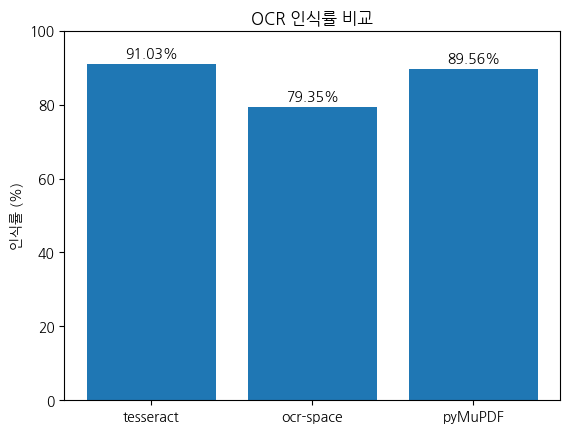

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


font_path = '/home/ubuntu/flask_app/1103/NanumGothic.ttf'
fm.fontManager.addfont(font_path)   # 폰트 추가
plt.rc('font', family='NanumGothic')  # 직접 이름 지정

image_names= ['tesseract','ocr-space','pyMuPDF']
accuracies = [accuracy_01, accuracy_02, accuracy_03]


bars = plt.bar(image_names, accuracies)
for i, bar in enumerate(bars):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 1,  # 위치 (가운데, 막대 위 1만큼 띄움)
             f"{accuracies[i]:.2f}%",                # 표시할 텍스트
             ha='center', va='bottom', fontsize=10)
plt.title("OCR 인식률 비교")
plt.ylabel("인식률 (%)")
plt.ylim(0,100)
plt.show()

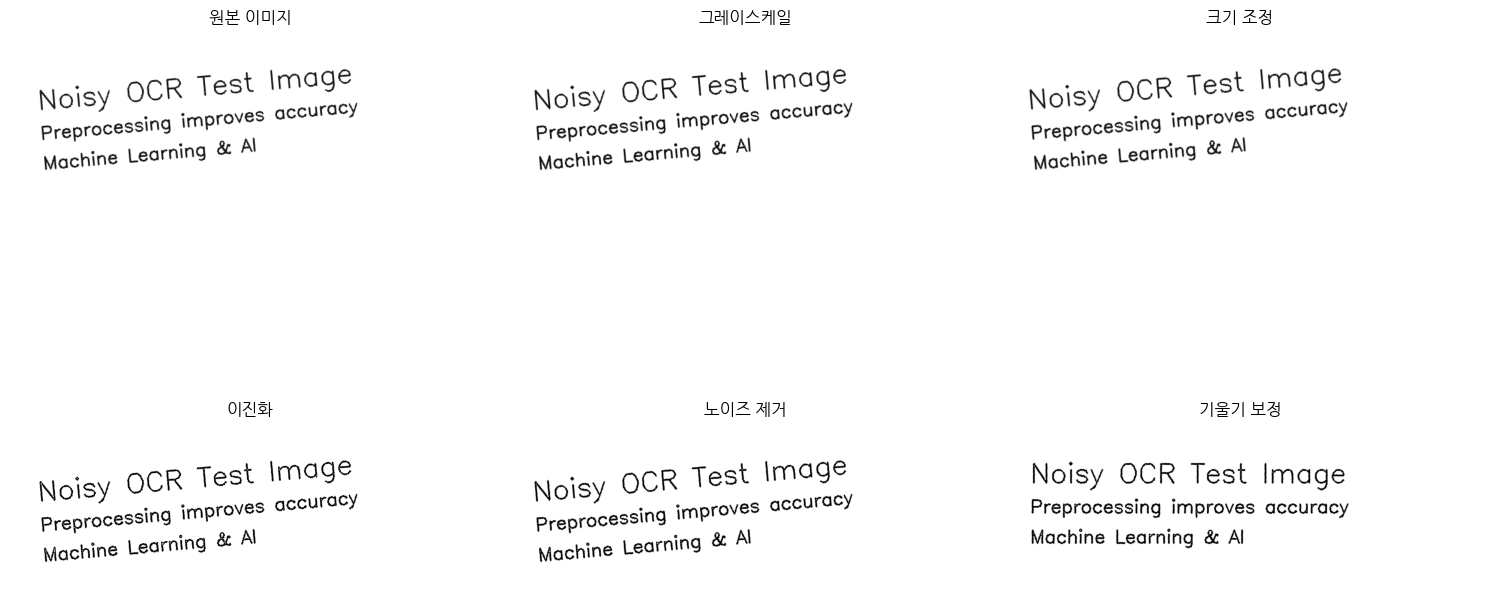

전처리 전 OCR 결과:
'CR Test Image\n\nccuracy\n\nNoisy 0\nPreprocessing improves 4\nMachine Learning & Al\n'

전처리 후 OCR 결과:
'Noisy OCR Test Image\nPreprocessing improves accuracy\nMachine Learning & Al\n'


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]],
      shape=(800, 2133), dtype=uint8)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

class OCRPreprocessor:
    
    def __init__(self):
        pass
        
    # 1. 이미지가 컬러(BGR)이면 그레이스케일로 변환
    def convert_to_grayscale(self, image):
        if len(image.shape) == 3:
            # bgr을 그레이스케일로 변환
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            # 이미 그레이스케일이면 복사
            gray = image.copy()
        return gray
        
    # 2. 이미지 이진화 (흑/백으로 바꿈)    
    def apply_threshold(self, image, method='adaptive'):
        gray = self.convert_to_grayscale(image)
        if method == 'simple':
            # 127보다 밝으면 255 어두우면 0
            _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
            # _: 임계값 반환, thresh : 이진화된 이미지 반환
                
        elif method == 'adaptive':
            thresh = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
            # 이미지 / 최대값 / 가우시안 가중평균 임계값 / 이진화 방법 / 영역 크기 / 상수 값
        
        elif method == 'otsu': #히스토그램 분석으로 임계값 선택
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            # 이미지/ 임계값/ 최대값 / 이진화 방법
        return thresh 
        
    # 3. 이미지 노이즈 제거    
    def remove_noise(self, image): 
        kernel = np.ones((3,3), np.uint8)
        # 3*3 구조 생성 / 이미지의 픽셀 값을 변경하는 연산
        opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        # 얄림 연산: 작은 노이즈 점들을 제거
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
        # 닫힘 연산: 텍스트 내부의 작은 구멍들을 메움
        ### 커널보다 작으면 노이즈로 간주하고 제거하는 연산임.
        denoised = cv2.GaussianBlur(closing, (3,3), 0)
        # 중앙값으로 노이즈 제거
        return denoised # 누락된 return문 추가
        
    # 4. 이미지의 기울기를 보정
    def correct_skew(self, image):
        edges = cv2.Canny(image, 50, 150, apertureSize=3)
        # cannny 에지 검출: 50-150 임계값으로 윤곽선 추출
        # 3*3 커널 이용ㅣ 급격하게 어둡/밝아지는 변화를 감지함.(그부분이 윤곽선 후보
        # 50-150 임계 사용 ㅣ 50밑이면 아님, 150 이상이면 윤곽선임, 그 사이면 애매
        
        lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100) # 'edge' -> 'edges' 오타 수정
        # 허프 변환으로 직선 검출
        # 거리해상도 1, 각도해상도 1도, th=100: 최소 점 수(100개 이상이어야 직선)
        
        if lines is not None:
            angles = []
            for rho, theta in lines[:,0]: #배열이 3겹이라서.. 0으로 제거
                # 'lines' 배열에 있는 모든 직선 정보를 하나씩 꺼내 반복
                angle = np.degrees(theta) - 90
                angles.append(angle) #앵글 리스트에 변환한 각도 저장
            
            # 모든 각도를 수집한 후 반복문 밖에서 한 번만 계산 (논리 오류 수정)
            median_angle = np.median(angles) #중간값 계산(전체적으로 그만큼 기울어짐)
            (h, w) = image.shape[:2] 
            center = (w // 2, h // 2) #이미지 정중앙 계산
            M = cv2.getRotationMatrix2D(center, median_angle, 1.0) # 'Matriz2D' -> 'Matrix2D' 오타 수정, #회전행렬
            rotated = cv2.warpAffine(image, M, (w, h), 
                                     flags=cv2.INTER_CUBIC,
                                     borderMode=cv2.BORDER_REPLICATE) # 'wrapAffine' -> 'warpAffine' 오타 수정
            return rotated # 'rotate' -> 'rotated' 오타 수정
            
        return image

    def resize_image(self, image, target_height=800):
        h, w = image.shape[:2]
        # 이미지의 높이가 목표 높이보다 작을 때만 리사이즈 실행
        if h < target_height:
            # 비율 계산 (목표 높이 / 현재 높이)
            scale = target_height / h
            # 새로운 너비 계산
            new_w = int(w * scale)
            # 이미지 리사이즈
            resized = cv2.resize(image, (new_w, target_height), interpolation=cv2.INTER_CUBIC)
        else:
            # 목표 높이보다 크거나 같으면 원본 이미지 그대로 반환
            resized = image
        return resized

    def visualize_preprocessing_steps(self, steps, step_names):
        """전처리 과정을 단계별로 시각화"""
        # 한글 깨짐 방지를 위한 폰트 설정
        plt.rc('font', family='NanumGothic')
        # 2행 3열의 서브플롯(그래프 칸)을 생성
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        # 2차원 배열 형태의 axes를 1차원 배열로 변환
        # for문으로 각 칸에 순차적으로 접근하기 쉽게 만듦
        axes = axes.ravel()
        # 각 처리 단계별 이미지를 서브플롯에 출력
        for i, (step, name) in enumerate(zip(steps, step_names)):
            # i에는 0, 1, 2... 순서 번호가, step에는 이미지가, name에는 이미지의 이름이 들어감
            # 준비된 서브플롯의 개수를 넘지 않도록 확인
            if i < len(axes):
                # 컬러 이미지인 경우 (채널이 3개)
                if len(step.shape) == 3:
                    # OpenCV(BGR) -> Matplotlib(RGB) 색상 순서 변환 후 출력
                    axes[i].imshow(cv2.cvtColor(step, cv2.COLOR_BGR2RGB))
                # 흑백(grayscale) 이미지인 경우
                else:
                    axes[i].imshow(step, cmap='gray')
                # 각 이미지에 제목 설정
                axes[i].set_title(name)
                # 불필요한 축 숨기기
                axes[i].axis('off')
        
        # 서브플롯 간의 간격을 자동으로 조절
        plt.tight_layout()
        # 최종 결과물을 화면에 표시
        plt.show()

    def preprocess_pipeline(self, image, visualize=False):
        """전체 이미지 전처리 파이프라인 실행"""
        # 각 처리 단계별 결과 저장용 리스트
        steps = []
        step_names = []
        
        # 0. 원본 이미지 보존
        steps.append(image.copy())
        step_names.append('원본 이미지')
        
        # 1. 그레이스케일 변환
        gray = self.convert_to_grayscale(image)
        steps.append(gray)
        step_names.append('그레이스케일')
        
        # 2. OCR 최적화를 위한 크기 조정
        resized = self.resize_image(gray)
        steps.append(resized)
        step_names.append('크기 조정')
        
        # 3. 적응적 이진화 처리 (지역적 밝기 변화에 강건)
        thresh = self.apply_threshold(resized, method='adaptive')
        steps.append(thresh)
        step_names.append('이진화')

        # 4. 모폴로지 연산으로 노이즈 제거
        denoised = self.remove_noise(thresh)
        steps.append(denoised)
        step_names.append('노이즈 제거')

        # 5. 허프 변환 기반 기울기 자동 보정
        corrected = self.correct_skew(denoised)
        steps.append(corrected)
        step_names.append('기울기 보정')

        # 시각화 옵션이 활성화된 경우 처리 과정 출력
        if visualize:
            self.visualize_preprocessing_steps(steps, step_names)
        
        return corrected

# --- 아래 함수들은 클래스 외부에 정의 ---

def create_noisy_sample_image():
    """테스트용 노이즈가 있는 샘플 이미지 생성"""
    image = np.ones((300, 800, 3), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, 'Noisy OCR Test Image', (50, 100), font, 1.5, (0, 0, 0), 2)
    cv2.putText(image, 'Preprocessing improves accuracy', (50, 150), font, 1, (0, 0, 0), 2)
    cv2.putText(image, 'Machine Learning & AI', (50, 200), font, 1, (0, 0, 0), 2)
    
    noise = np.random.randint(0, 50, image.shape, dtype=np.uint8)
    noisy_image = cv2.add(image, noise)
    
    h, w = noisy_image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, 5, 1.0) # 5도 회전
    skewed_image = cv2.warpAffine(noisy_image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    
    return skewed_image

def preprocessing_example():
    """OCR 전처리 예제 실행 함수"""
    preprocessor = OCRPreprocessor()
    image = cv2.imread('01.jpg')
    processed_image = preprocessor.preprocess_pipeline(image, visualize=True)
    
    try:
        import pytesseract
        original_text = pytesseract.image_to_string(image)
        processed_text = pytesseract.image_to_string(processed_image)
        
        print("전처리 전 OCR 결과:")
        print(repr(original_text))
        print("\n전처리 후 OCR 결과:")
        print(repr(processed_text))
        
    except ImportError:
        print("pytesseract가 설치되지 않아 OCR 비교를 건너뜁니다.")
        print("설치: pip install pytesseract")
        
    return processed_image


preprocessing_example()